# 2021101062
# Siya Puttagunta
# Assignment 2

## 1

Imports

In [2]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from torchvision import datasets
import matplotlib.pyplot as plt

Loading Data

In [41]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

Display Images

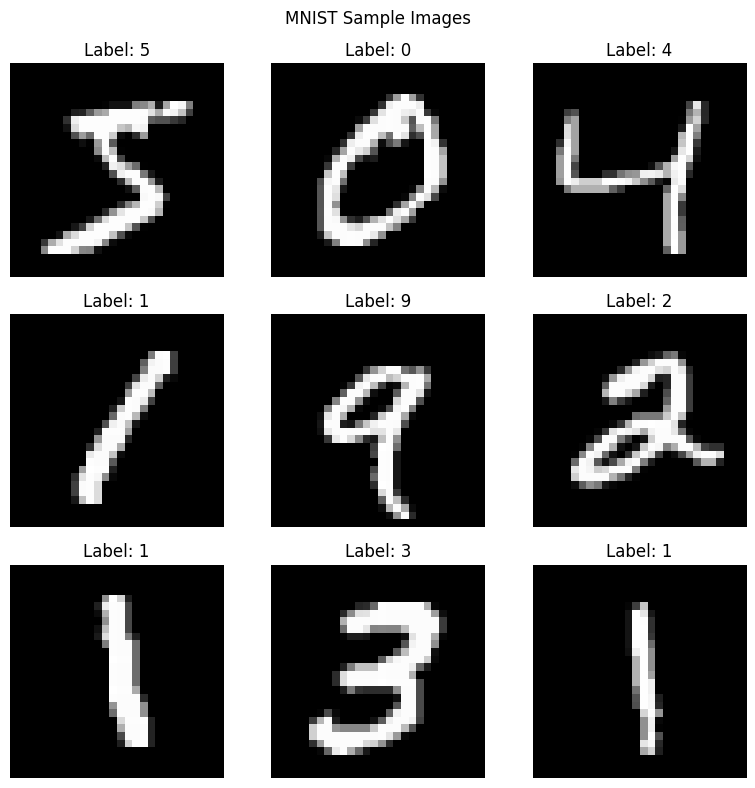

In [42]:
num_images = 9
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('MNIST Sample Images')

for i, ax in enumerate(axes.flat):
    image, label = mnist_train[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Splitting Data

In [43]:
X_train, y_train = mnist_train.data.numpy(), mnist_train.targets.numpy()
X_test, y_test = mnist_test.data.numpy(), mnist_test.targets.numpy()

### 1.1

In [44]:
def sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

def compute_visual_words(X_train, n_clusters=100):
    sift = cv2.SIFT_create()
    descriptors_list = []

    for image in X_train:
        kp, des = sift.detectAndCompute(image, None)
        if des is not None:
            descriptors_list.append(des)

    descriptors = np.vstack(descriptors_list)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(descriptors)
    visual_words = kmeans.cluster_centers_
    
    return visual_words

def image_histogram(image, visual_words, n_clusters=100):
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)

    if des is None:
        return np.zeros(n_clusters)
    else:
        distances = np.linalg.norm(des[:, np.newaxis, :] - visual_words[np.newaxis, :, :], axis=2)
        histogram, _ = np.histogram(np.argmin(distances, axis=1), bins=n_clusters, range=(0, n_clusters))
        return histogram / np.sum(histogram)

Computing visual words and histograms for train set

In [45]:
visual_words = compute_visual_words(X_train)

X_train_hist = np.array([image_histogram(image, visual_words) for image in X_train])

Training linear SVM model

In [46]:
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_hist, y_train)

LinearSVC(random_state=42)

Evaluation on test set

In [47]:
X_test_hist = np.array([image_histogram(image, visual_words) for image in X_test])
predictions = svm_model.predict(X_test_hist)
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy * 100, "%")

Accuracy: 73.05 %


### 1.2

Accuracy vs Number of Clusters

In [48]:
cluster_values = [10, 20, 50, 100, 200, 500]
accuracies = []

for n_clusters in cluster_values:
    visual_words = compute_visual_words(X_train, n_clusters=n_clusters)
    X_train_hist = np.array([image_histogram(image, visual_words, n_clusters=n_clusters) for image in X_train])

    svm_model = LinearSVC(random_state=42)
    svm_model.fit(X_train_hist, y_train)

    X_test_hist = np.array([image_histogram(image, visual_words, n_clusters=n_clusters) for image in X_test])
    predictions = svm_model.predict(X_test_hist)
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy * 100)

for i in range(len(cluster_values)):
    print("Accuracy for", cluster_values[i], "clusters:", accuracies[i], "%")

Accuracy for 10 clusters: 37.230000000000004 %
Accuracy for 20 clusters: 47.61 %
Accuracy for 50 clusters: 63.68000000000001 %
Accuracy for 100 clusters: 73.03 %
Accuracy for 200 clusters: 78.42 %
Accuracy for 500 clusters: 82.89999999999999 %


Plotting the results

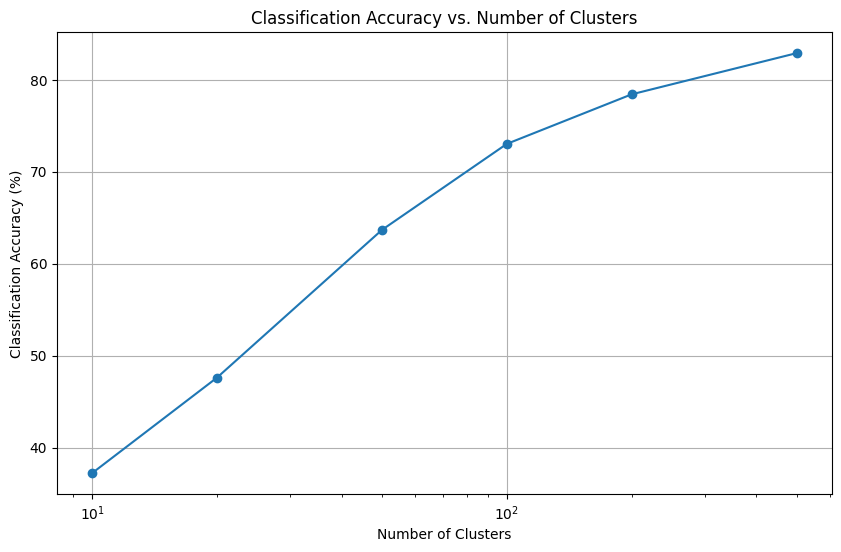

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Number of Clusters')
plt.ylabel('Classification Accuracy (%)')
plt.title('Classification Accuracy vs. Number of Clusters')
plt.grid(True)
plt.show()

- Highest accuracy achieved is for 500 clusters which is 82.89%.
- As the number of clusters increases, the classification accuracy increases.
- The increase in accuracy is significant in the early stages.

### 1.3

Hyperparameter tuning for various sift_nfeatures and svm_C

In [50]:
hyperparameter_settings = [
    {'sift_nfeatures': 0, 'svm_C': 1.0, 'sift_edgeThreshold': 10},  
    {'sift_nfeatures': 500, 'svm_C': 1.0, 'sift_edgeThreshold': 10},  
    {'sift_nfeatures': 0, 'svm_C': 0.1, 'sift_edgeThreshold': 5},  
    {'sift_nfeatures': 500, 'svm_C': 0.1, 'sift_edgeThreshold': 5},  
    {'sift_nfeatures': 100, 'svm_C': 10.0, 'sift_edgeThreshold': 10},  
    {'sift_nfeatures': 0, 'svm_C': 10.0, 'sift_edgeThreshold': 10},  
]

Computing Accuracy for 100 Clusters

In [51]:
accuracies = []

for params in hyperparameter_settings:
    visual_words = compute_visual_words(X_train, n_clusters=100) 
    
    sift_nfeatures = params['sift_nfeatures']
    sift_edgeThreshold = params.get('sift_edgeThreshold', 10)  
    
    if sift_nfeatures > 0:
        cv2.setNumThreads(0)  
        sift = cv2.SIFT_create(nfeatures=sift_nfeatures, edgeThreshold=sift_edgeThreshold) 
    else:
        sift = cv2.SIFT_create(edgeThreshold=sift_edgeThreshold) 

    svm_C = params['svm_C']
    svm_model = LinearSVC(C=svm_C, random_state=42)
    
    X_train_hist = np.array([image_histogram(image, visual_words) for image in X_train])
    svm_model.fit(X_train_hist, y_train)

    X_test_hist = np.array([image_histogram(image, visual_words) for image in X_test])
    predictions = svm_model.predict(X_test_hist)
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy * 100.0)

for i in range(len(hyperparameter_settings)):
    print("Accuracy for", hyperparameter_settings[i], ":", accuracies[i], "%")

Accuracy for {'sift_nfeatures': 0, 'svm_C': 1.0, 'sift_edgeThreshold': 10} : 73.02 %
Accuracy for {'sift_nfeatures': 500, 'svm_C': 1.0, 'sift_edgeThreshold': 10} : 73.07000000000001 %
Accuracy for {'sift_nfeatures': 0, 'svm_C': 0.1, 'sift_edgeThreshold': 5} : 72.23 %
Accuracy for {'sift_nfeatures': 500, 'svm_C': 0.1, 'sift_edgeThreshold': 5} : 72.2 %
Accuracy for {'sift_nfeatures': 100, 'svm_C': 10.0, 'sift_edgeThreshold': 10} : 73.08 %
Accuracy for {'sift_nfeatures': 0, 'svm_C': 10.0, 'sift_edgeThreshold': 10} : 73.11 %


PLotting the results

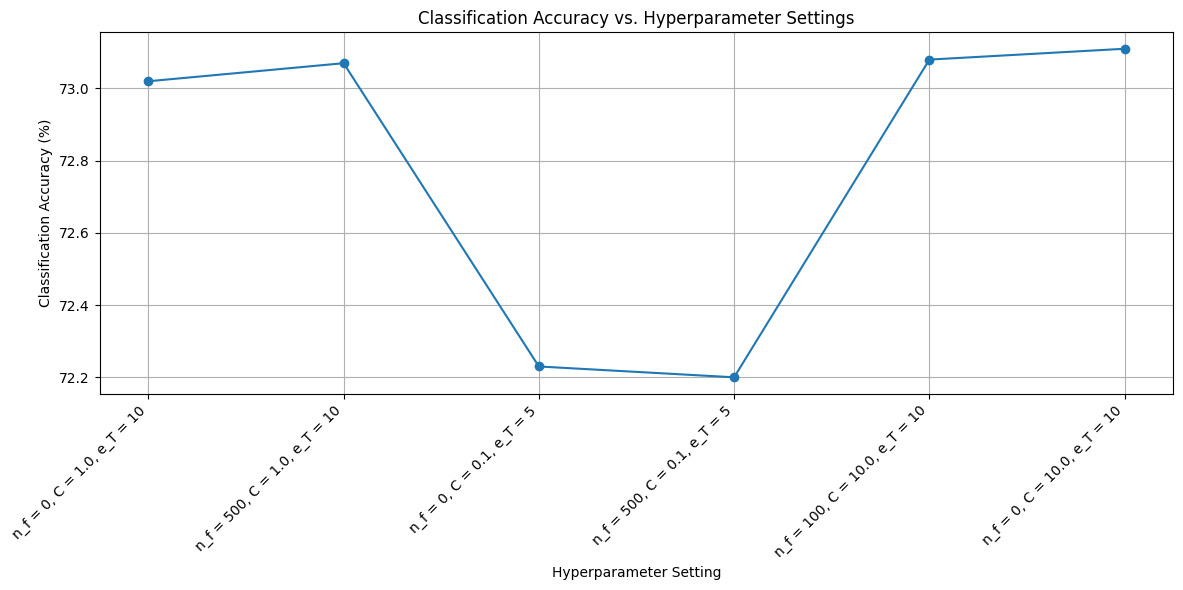

In [52]:
labels = [
    f"n_f = {params['sift_nfeatures']}, C = {params['svm_C']}, e_T = {params['sift_edgeThreshold']}"
    for params in hyperparameter_settings
]

plt.figure(figsize=(12, 6))
plt.plot(range(1, 7), accuracies, marker='o')
plt.xlabel('Hyperparameter Setting')
plt.ylabel('Classification Accuracy (%)')
plt.title('Classification Accuracy vs. Hyperparameter Settings')
plt.xticks(range(1, 7), labels, rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

- Accuracy remains almost same for all hyperparameter configurations (72-73%).

## 2

Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import wandb

### 2.1

Data Module

In [4]:
class DigitDataset(torch.utils.data.Dataset):
    def __init__(self, train):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        self.dataset = torchvision.datasets.MNIST(root='./data', train=train, download=True, transform=self.transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

Model Module

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Train Function

In [6]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs, labels
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total

    return train_loss, train_accuracy

Test Function

In [7]:
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs, labels
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    
    return test_loss, test_accuracy

Setting hyperparameters and loading data

In [8]:
torch.manual_seed(42)

lr = 0.001
epochs = 10
batch_size = 64

train_dataset = DigitDataset(train=True)
test_dataset = DigitDataset(train=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Number of training and testing samples

In [59]:
n_train = len(train_dataset)
n_test = len(test_dataset)

print(f"Training samples: {n_train}")
print(f"Testing samples: {n_test}")

Training samples: 60000
Testing samples: 10000


Accuracy of train and test samples

In [60]:
wandb.init(project='digit-recognition')

model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
train_accuracy_list = []

test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = test(model, test_loader, criterion)

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    wandb.log({
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    })

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10, Train Loss: 0.2552, Train Accuracy: 91.95%, Test Loss: 0.0708, Test Accuracy: 97.59%
Epoch 2/10, Train Loss: 0.0691, Train Accuracy: 97.83%, Test Loss: 0.0442, Test Accuracy: 98.42%
Epoch 3/10, Train Loss: 0.0507, Train Accuracy: 98.45%, Test Loss: 0.0514, Test Accuracy: 98.44%
Epoch 4/10, Train Loss: 0.0394, Train Accuracy: 98.83%, Test Loss: 0.0405, Test Accuracy: 98.67%
Epoch 5/10, Train Loss: 0.0327, Train Accuracy: 98.98%, Test Loss: 0.0330, Test Accuracy: 98.88%
Epoch 6/10, Train Loss: 0.0266, Train Accuracy: 99.14%, Test Loss: 0.0341, Test Accuracy: 98.83%
Epoch 7/10, Train Loss: 0.0250, Train Accuracy: 99.18%, Test Loss: 0.0342, Test Accuracy: 98.91%
Epoch 8/10, Train Loss: 0.0206, Train Accuracy: 99.29%, Test Loss: 0.0387, Test Accuracy: 98.82%
Epoch 9/10, Train Loss: 0.0180, Train Accuracy: 99.42%, Test Loss: 0.0397, Test Accuracy: 98.80%
Epoch 10/10, Train Loss: 0.0152, Train Accuracy: 99.50%, Test Loss: 0.0359, Test Accuracy: 98.85%


Plotting the results

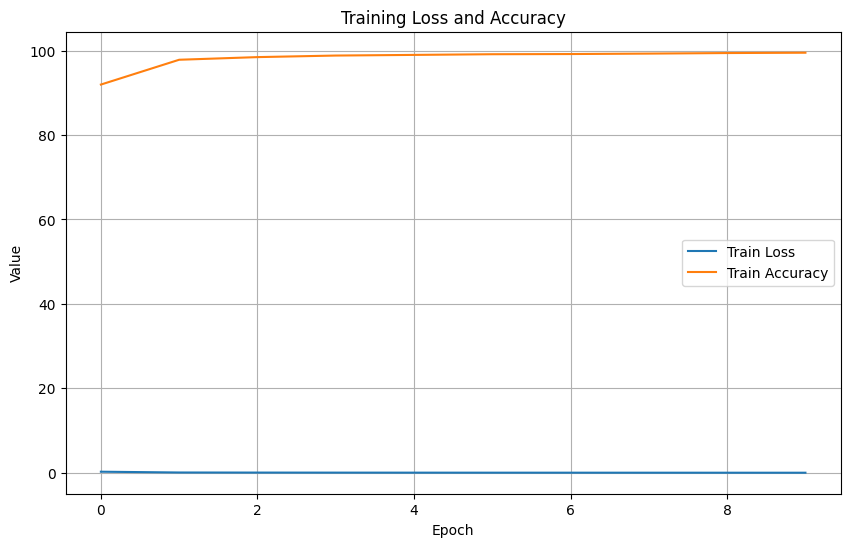

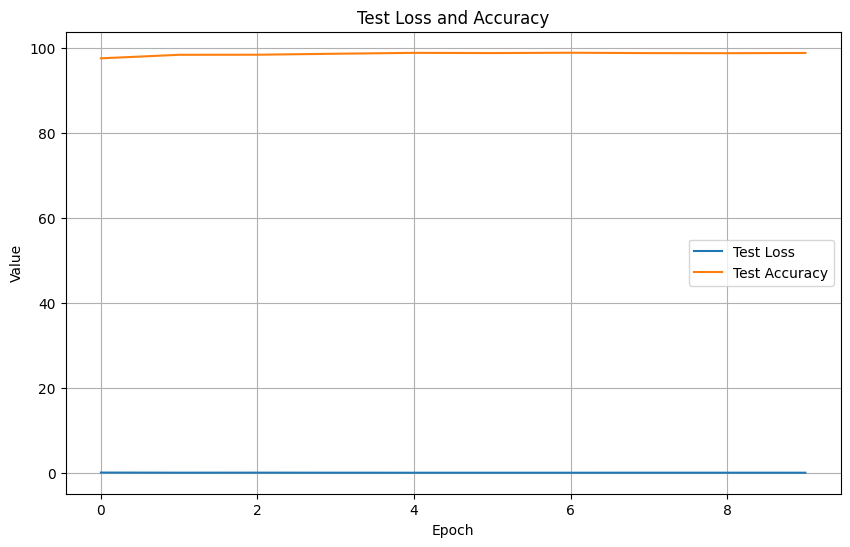

In [61]:
# Train
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Test
plt.figure(figsize=(10, 6))
plt.plot(test_loss_list, label='Test Loss')
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Test Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 2.2

Hyperparameter tuning

In [9]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'test_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.001, 0.01]
        },
        'batch_size': {
            'values': [64, 128]
        },
        'optimizer': {
            'values': ['adam', 'sgd']
        },
        'epochs': {
            'values': [10]
        },
    }
}

In [10]:
def main():
    config_defaults = { 'lr': 0.001, 'batch_size': 64, 'optimizer': 'adam', 'epochs': 10 }

    wandb.init(project='digit-recognition', config=config_defaults)
    config=wandb.config

    model = LeNet()

    criterion = nn.CrossEntropyLoss()
    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=config.lr)

    train_loss_list = []
    train_accuracy_list = []

    test_loss_list = []
    test_accuracy_list = []

    for epoch in range(config.epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
        test_loss, test_accuracy = test(model, test_loader, criterion)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        print(f'Epoch {epoch+1}/{config.epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    wandb.log({
        'train_loss': train_loss_list[-1],
        'train_accuracy': train_accuracy_list[-1],
        'test_loss': test_loss_list[-1],
        'test_accuracy': test_accuracy_list[-1]
    })

sweep_id = wandb.sweep(sweep_config, project='digit-recognition')
wandb.agent(sweep_id, function=main)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: y3ylarvq
Sweep URL: https://wandb.ai/siya26/digit-recognition/sweeps/y3ylarvq


wandb: Agent Starting Run: m74ft0k0 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: siyaputtagunta (siya26). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
2024-03-08 20:03:35.573636: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 20:03:35.770448: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 20:03:35.770487: E tensorflow/compiler

Epoch 1/10, Train Loss: 0.2552, Train Accuracy: 91.95%, Test Loss: 0.0708, Test Accuracy: 97.59%
Epoch 2/10, Train Loss: 0.0691, Train Accuracy: 97.83%, Test Loss: 0.0442, Test Accuracy: 98.42%
Epoch 3/10, Train Loss: 0.0507, Train Accuracy: 98.45%, Test Loss: 0.0514, Test Accuracy: 98.44%
Epoch 4/10, Train Loss: 0.0394, Train Accuracy: 98.83%, Test Loss: 0.0405, Test Accuracy: 98.67%
Epoch 5/10, Train Loss: 0.0327, Train Accuracy: 98.98%, Test Loss: 0.0330, Test Accuracy: 98.88%
Epoch 6/10, Train Loss: 0.0266, Train Accuracy: 99.14%, Test Loss: 0.0341, Test Accuracy: 98.83%
Epoch 7/10, Train Loss: 0.0250, Train Accuracy: 99.18%, Test Loss: 0.0342, Test Accuracy: 98.91%
Epoch 8/10, Train Loss: 0.0206, Train Accuracy: 99.29%, Test Loss: 0.0387, Test Accuracy: 98.82%
Epoch 9/10, Train Loss: 0.0180, Train Accuracy: 99.42%, Test Loss: 0.0397, Test Accuracy: 98.80%
Epoch 10/10, Train Loss: 0.0152, Train Accuracy: 99.50%, Test Loss: 0.0359, Test Accuracy: 98.85%


test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
test_accuracy,98.85
test_loss,0.03593
train_accuracy,99.495
train_loss,0.01521


wandb: Agent Starting Run: ff63zs86 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
2024-03-08 20:05:27.966887: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 20:05:28.002882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 20:05:28.002919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register fa

Epoch 1/10, Train Loss: 2.2999, Train Accuracy: 9.95%, Test Loss: 2.2965, Test Accuracy: 10.41%
Epoch 2/10, Train Loss: 2.2942, Train Accuracy: 11.34%, Test Loss: 2.2903, Test Accuracy: 14.47%
Epoch 3/10, Train Loss: 2.2873, Train Accuracy: 19.69%, Test Loss: 2.2819, Test Accuracy: 26.46%
Epoch 4/10, Train Loss: 2.2767, Train Accuracy: 26.24%, Test Loss: 2.2680, Test Accuracy: 27.35%
Epoch 5/10, Train Loss: 2.2570, Train Accuracy: 32.35%, Test Loss: 2.2394, Test Accuracy: 36.99%
Epoch 6/10, Train Loss: 2.2123, Train Accuracy: 38.65%, Test Loss: 2.1667, Test Accuracy: 42.03%
Epoch 7/10, Train Loss: 2.0640, Train Accuracy: 43.81%, Test Loss: 1.8755, Test Accuracy: 50.91%
Epoch 8/10, Train Loss: 1.5021, Train Accuracy: 62.48%, Test Loss: 1.0314, Test Accuracy: 77.07%
Epoch 9/10, Train Loss: 0.7776, Train Accuracy: 80.93%, Test Loss: 0.5655, Test Accuracy: 84.46%
Epoch 10/10, Train Loss: 0.5088, Train Accuracy: 85.89%, Test Loss: 0.4289, Test Accuracy: 87.57%


test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
test_accuracy,87.57
test_loss,0.42889
train_accuracy,85.88833
train_loss,0.50881


wandb: Agent Starting Run: jr1hutjm with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	lr: 0.01
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
2024-03-08 20:07:11.199253: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 20:07:11.233879: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 20:07:11.233915: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register fa

Epoch 1/10, Train Loss: 0.1762, Train Accuracy: 94.67%, Test Loss: 0.0948, Test Accuracy: 97.31%
Epoch 2/10, Train Loss: 0.1007, Train Accuracy: 97.25%, Test Loss: 0.0768, Test Accuracy: 97.92%
Epoch 3/10, Train Loss: 0.0867, Train Accuracy: 97.72%, Test Loss: 0.0769, Test Accuracy: 98.08%
Epoch 4/10, Train Loss: 0.0815, Train Accuracy: 97.89%, Test Loss: 0.0882, Test Accuracy: 97.81%
Epoch 5/10, Train Loss: 0.0811, Train Accuracy: 97.97%, Test Loss: 0.0895, Test Accuracy: 98.21%
Epoch 6/10, Train Loss: 0.0862, Train Accuracy: 98.02%, Test Loss: 0.1211, Test Accuracy: 96.83%
Epoch 7/10, Train Loss: 0.0768, Train Accuracy: 98.23%, Test Loss: 0.0981, Test Accuracy: 97.71%
Epoch 8/10, Train Loss: 0.0782, Train Accuracy: 98.30%, Test Loss: 0.2264, Test Accuracy: 96.38%
Epoch 9/10, Train Loss: 0.0825, Train Accuracy: 98.25%, Test Loss: 0.0806, Test Accuracy: 98.21%
Epoch 10/10, Train Loss: 0.0744, Train Accuracy: 98.48%, Test Loss: 0.0866, Test Accuracy: 98.01%


test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
test_accuracy,98.01
test_loss,0.0866
train_accuracy,98.47833
train_loss,0.07441


wandb: Agent Starting Run: zcw194vn with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	lr: 0.01
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
2024-03-08 20:08:59.834533: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 20:08:59.874752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 20:08:59.874790: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register fac

Epoch 1/10, Train Loss: 1.7665, Train Accuracy: 45.52%, Test Loss: 0.4643, Test Accuracy: 86.66%
Epoch 2/10, Train Loss: 0.3016, Train Accuracy: 90.96%, Test Loss: 0.2045, Test Accuracy: 93.56%
Epoch 3/10, Train Loss: 0.1862, Train Accuracy: 94.25%, Test Loss: 0.1474, Test Accuracy: 95.38%
Epoch 4/10, Train Loss: 0.1390, Train Accuracy: 95.66%, Test Loss: 0.1154, Test Accuracy: 96.26%
Epoch 5/10, Train Loss: 0.1130, Train Accuracy: 96.42%, Test Loss: 0.0937, Test Accuracy: 97.12%
Epoch 6/10, Train Loss: 0.0958, Train Accuracy: 97.01%, Test Loss: 0.0792, Test Accuracy: 97.48%
Epoch 7/10, Train Loss: 0.0840, Train Accuracy: 97.34%, Test Loss: 0.0755, Test Accuracy: 97.46%
Epoch 8/10, Train Loss: 0.0753, Train Accuracy: 97.65%, Test Loss: 0.0669, Test Accuracy: 97.86%
Epoch 9/10, Train Loss: 0.0684, Train Accuracy: 97.87%, Test Loss: 0.0684, Test Accuracy: 97.79%
Epoch 10/10, Train Loss: 0.0631, Train Accuracy: 98.00%, Test Loss: 0.0689, Test Accuracy: 97.67%


test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
test_accuracy,97.67
test_loss,0.06891
train_accuracy,98.0
train_loss,0.06315


wandb: Agent Starting Run: ahzt6831 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
2024-03-08 20:10:50.277364: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 20:10:50.311089: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 20:10:50.311127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register 

Epoch 1/10, Train Loss: 0.2619, Train Accuracy: 91.98%, Test Loss: 0.0717, Test Accuracy: 97.83%
Epoch 2/10, Train Loss: 0.0738, Train Accuracy: 97.66%, Test Loss: 0.0531, Test Accuracy: 98.23%
Epoch 3/10, Train Loss: 0.0535, Train Accuracy: 98.31%, Test Loss: 0.0458, Test Accuracy: 98.53%
Epoch 4/10, Train Loss: 0.0428, Train Accuracy: 98.64%, Test Loss: 0.0406, Test Accuracy: 98.70%
Epoch 5/10, Train Loss: 0.0344, Train Accuracy: 98.92%, Test Loss: 0.0377, Test Accuracy: 98.81%
Epoch 6/10, Train Loss: 0.0290, Train Accuracy: 99.03%, Test Loss: 0.0352, Test Accuracy: 98.79%
Epoch 7/10, Train Loss: 0.0252, Train Accuracy: 99.15%, Test Loss: 0.0420, Test Accuracy: 98.78%
Epoch 8/10, Train Loss: 0.0211, Train Accuracy: 99.33%, Test Loss: 0.0301, Test Accuracy: 99.04%
Epoch 9/10, Train Loss: 0.0190, Train Accuracy: 99.40%, Test Loss: 0.0351, Test Accuracy: 98.99%
Epoch 10/10, Train Loss: 0.0162, Train Accuracy: 99.50%, Test Loss: 0.0369, Test Accuracy: 98.83%


test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
test_accuracy,98.83
test_loss,0.03694
train_accuracy,99.49667
train_loss,0.01624


wandb: Agent Starting Run: 4oxinghu with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
2024-03-08 20:12:37.249090: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 20:12:37.282255: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 20:12:37.282292: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register f

Epoch 1/10, Train Loss: 2.3008, Train Accuracy: 10.22%, Test Loss: 2.2987, Test Accuracy: 10.10%
Epoch 2/10, Train Loss: 2.2976, Train Accuracy: 10.23%, Test Loss: 2.2955, Test Accuracy: 10.14%
Epoch 3/10, Train Loss: 2.2942, Train Accuracy: 10.89%, Test Loss: 2.2917, Test Accuracy: 12.57%
Epoch 4/10, Train Loss: 2.2898, Train Accuracy: 17.09%, Test Loss: 2.2865, Test Accuracy: 23.73%
Epoch 5/10, Train Loss: 2.2833, Train Accuracy: 28.56%, Test Loss: 2.2782, Test Accuracy: 32.16%
Epoch 6/10, Train Loss: 2.2727, Train Accuracy: 34.20%, Test Loss: 2.2640, Test Accuracy: 37.15%
Epoch 7/10, Train Loss: 2.2527, Train Accuracy: 41.25%, Test Loss: 2.2346, Test Accuracy: 43.46%
Epoch 8/10, Train Loss: 2.2036, Train Accuracy: 42.17%, Test Loss: 2.1517, Test Accuracy: 40.71%
Epoch 9/10, Train Loss: 2.0374, Train Accuracy: 40.58%, Test Loss: 1.8426, Test Accuracy: 45.61%
Epoch 10/10, Train Loss: 1.5185, Train Accuracy: 58.93%, Test Loss: 1.1200, Test Accuracy: 72.24%


test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
test_accuracy,72.24
test_loss,1.11999
train_accuracy,58.92833
train_loss,1.51847


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mn5ymkc0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	lr: 0.01
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
2024-03-08 20:14:29.196344: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 20:14:29.230091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 20:14:29.230130: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] 

Epoch 1/10, Train Loss: 0.1761, Train Accuracy: 94.71%, Test Loss: 0.1289, Test Accuracy: 96.73%
Epoch 2/10, Train Loss: 0.0966, Train Accuracy: 97.43%, Test Loss: 0.0896, Test Accuracy: 97.75%
Epoch 3/10, Train Loss: 0.0924, Train Accuracy: 97.60%, Test Loss: 0.1002, Test Accuracy: 97.42%
Epoch 4/10, Train Loss: 0.0832, Train Accuracy: 97.88%, Test Loss: 0.0864, Test Accuracy: 98.25%
Epoch 5/10, Train Loss: 0.0800, Train Accuracy: 98.03%, Test Loss: 0.0783, Test Accuracy: 98.14%
Epoch 6/10, Train Loss: 0.0831, Train Accuracy: 98.09%, Test Loss: 0.0742, Test Accuracy: 98.24%
Epoch 7/10, Train Loss: 0.0780, Train Accuracy: 98.18%, Test Loss: 0.0786, Test Accuracy: 98.10%
Epoch 8/10, Train Loss: 0.0728, Train Accuracy: 98.33%, Test Loss: 0.0813, Test Accuracy: 98.20%
Epoch 9/10, Train Loss: 0.0789, Train Accuracy: 98.29%, Test Loss: 0.1135, Test Accuracy: 97.67%
Epoch 10/10, Train Loss: 0.0823, Train Accuracy: 98.25%, Test Loss: 0.1269, Test Accuracy: 96.93%


test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
test_accuracy,96.93
test_loss,0.12687
train_accuracy,98.245
train_loss,0.08229


wandb: Agent Starting Run: gsyn4zp4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	lr: 0.01
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
2024-03-08 20:16:17.405831: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 20:16:17.441804: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 20:16:17.441841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register fa

Epoch 1/10, Train Loss: 2.0199, Train Accuracy: 34.45%, Test Loss: 0.8466, Test Accuracy: 71.24%
Epoch 2/10, Train Loss: 0.3816, Train Accuracy: 88.62%, Test Loss: 0.2114, Test Accuracy: 93.65%
Epoch 3/10, Train Loss: 0.1904, Train Accuracy: 94.24%, Test Loss: 0.1364, Test Accuracy: 95.62%
Epoch 4/10, Train Loss: 0.1402, Train Accuracy: 95.80%, Test Loss: 0.1045, Test Accuracy: 96.78%
Epoch 5/10, Train Loss: 0.1146, Train Accuracy: 96.48%, Test Loss: 0.0849, Test Accuracy: 97.40%
Epoch 6/10, Train Loss: 0.0969, Train Accuracy: 97.03%, Test Loss: 0.0765, Test Accuracy: 97.62%
Epoch 7/10, Train Loss: 0.0847, Train Accuracy: 97.42%, Test Loss: 0.0743, Test Accuracy: 97.77%
Epoch 8/10, Train Loss: 0.0751, Train Accuracy: 97.70%, Test Loss: 0.0653, Test Accuracy: 97.97%
Epoch 9/10, Train Loss: 0.0682, Train Accuracy: 97.91%, Test Loss: 0.0581, Test Accuracy: 98.29%
Epoch 10/10, Train Loss: 0.0623, Train Accuracy: 98.07%, Test Loss: 0.0519, Test Accuracy: 98.22%


test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
test_accuracy,98.22
test_loss,0.05193
train_accuracy,98.07167
train_loss,0.06227


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Best Hyperparameters:
- Learning Rate: 0.001
- Batch Size: 128
- Optimizer: Adam

### Best Accuracy: 98.83%

- Important hyperparameters are learning rate and batch size.
- In general, adam optimizer gave better results than sgd optimizer and learning rate of 0.01 performed better than 0.001.

### 2.3

**The best performing CNN has an accuracy of 98.83% whereas, SIFT-BoVM-SVM approach has an accuracy of 73.11% which is quite less.**

The possible reasons are:-

- CNNs automatically learn hierarchical feature representations from raw pixel values, whereas traditional methods like SIFT rely on handcrafted feature engineering.

- CNNs preserve spatial information throughout the network, allowing them to capture spatial relationships between pixels in an image. In contrast, traditional methods like BoVW discard spatial information by representing images as histograms of visual words, which may limit their ability to capture spatial context.

### 2.4

In [11]:
class LeNetDouble(nn.Module):
    def __init__(self):
        super(LeNetDouble, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, padding=2)  
        self.conv4 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64*1*1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv4(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
wandb.init(project='digit-recognition')

lr = 0.001
epochs = 10

model = LeNetDouble()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
train_accuracy_list = []

test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = test(model, test_loader, criterion)

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    wandb.log({
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    })

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

wandb.finish()

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10, Train Loss: 0.3511, Train Accuracy: 88.21%, Test Loss: 0.0836, Test Accuracy: 97.28%
Epoch 2/10, Train Loss: 0.0849, Train Accuracy: 97.38%, Test Loss: 0.0559, Test Accuracy: 98.18%
Epoch 3/10, Train Loss: 0.0577, Train Accuracy: 98.22%, Test Loss: 0.0449, Test Accuracy: 98.49%
Epoch 4/10, Train Loss: 0.0460, Train Accuracy: 98.55%, Test Loss: 0.0479, Test Accuracy: 98.50%
Epoch 5/10, Train Loss: 0.0389, Train Accuracy: 98.75%, Test Loss: 0.0480, Test Accuracy: 98.56%
Epoch 6/10, Train Loss: 0.0347, Train Accuracy: 98.91%, Test Loss: 0.0329, Test Accuracy: 99.00%
Epoch 7/10, Train Loss: 0.0288, Train Accuracy: 99.15%, Test Loss: 0.0355, Test Accuracy: 98.96%
Epoch 8/10, Train Loss: 0.0265, Train Accuracy: 99.19%, Test Loss: 0.0403, Test Accuracy: 98.80%
Epoch 9/10, Train Loss: 0.0236, Train Accuracy: 99.27%, Test Loss: 0.0513, Test Accuracy: 98.72%
Epoch 10/10, Train Loss: 0.0196, Train Accuracy: 99.41%, Test Loss: 0.0383, Test Accuracy: 98.92%


test_accuracy,▁▅▆▆▆██▇▇█
test_loss,█▄▃▃▃▁▁▂▄▂
train_accuracy,▁▇▇▇██████
train_loss,█▂▂▂▁▁▁▁▁▁
test_accuracy,98.92
test_loss,0.03832
train_accuracy,99.405
train_loss,0.01957


- Accuracies of both the models are pretty similar (98-99%).

- As the number of convolutional layers is doubled, depth increases due to which model complexity is increased. This may lead to overfitting. In order to prevent this, regularization techniques might be useful.

Data Loader for different sizes of samples

In [9]:
def create_data_loader(train_dataset, subset_size):
    if subset_size == len(train_dataset):
        return torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    num_classes = 10
    class_samples = subset_size // num_classes
    indices = []
    for i in range(num_classes):
        indices.extend(np.where(train_dataset.dataset.targets == i)[0][:class_samples])
    sampler = torch.utils.data.SubsetRandomSampler(indices)
    return torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=sampler)

### 2.5

Test accuracy for different number of training samples

In [22]:
wandb.init(project='digit-recognition', config={'epochs': 10, 'learning_rate': 0.001})

subset_sizes = [600, 1800, 6000, 18000, 60000]
acc_list = []

for size in subset_sizes:
    train_loader = create_data_loader(train_dataset, size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    model = LeNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy})
    
    test_loss, accuracy = test(model, test_loader, criterion)
    print(f'Subset size: {size}, Test Accuracy: {accuracy:.4f}%')
    
    wandb.log({'test_loss': test_loss, 'test_accuracy': accuracy})
    acc_list.append(accuracy)

wandb.finish()

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Subset size: 600, Test Accuracy: 88.5600%
Subset size: 1800, Test Accuracy: 93.1400%
Subset size: 6000, Test Accuracy: 97.1600%
Subset size: 18000, Test Accuracy: 97.9000%
Subset size: 60000, Test Accuracy: 98.8500%


test_accuracy,▁▄▇▇█
test_loss,█▅▂▂▁
train_accuracy,▁▄▅▆▇▇▇▇▃▆▇▇▇▇██▅▇██████▇███████▇███████
train_loss,██▇▅▃▂▂▂▇▄▃▂▂▂▂▁▄▂▂▁▁▁▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
test_accuracy,98.85
test_loss,0.03979
train_accuracy,99.47667
train_loss,0.01592


Plotting the results

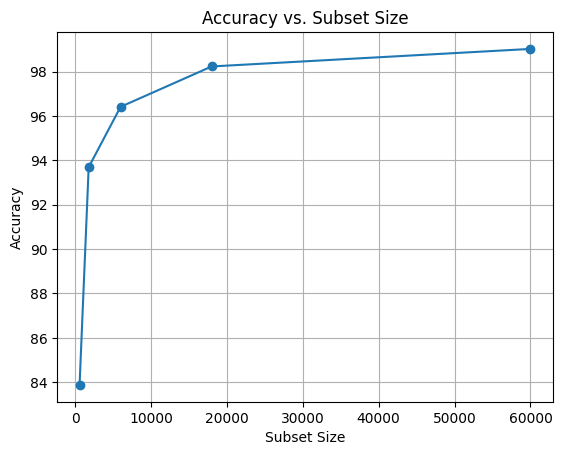

In [17]:
plt.plot(subset_sizes, acc_list, marker='o')
plt.xlabel('Subset Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Subset Size')
plt.grid(True)
plt.show()

- As the number of training samples increases, classification accuracy increases. 

- There is a steep rise in accuracy for lower values of subset size.

- We can observe that having a larger and more varied set of data has a favourable effect on model performance, improving accuracy and generalisation.

### 2.6

Vision Transformer

In [18]:
class VisionTransformer(nn.Module):
    def __init__(self, input_height, input_width, hidden_dim, num_classes, num_heads=2):
        super(VisionTransformer, self).__init__()
        self.input_dim = input_height * input_width
        self.embedding = nn.Linear(self.input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        x = self.fc(x)
        
        return x

Accuracy of ViT for different sizes of subset

In [20]:
subset_sizes = [6000, 60000]

for size in subset_sizes:
    train_loader = create_data_loader(train_dataset, size)
    
    model = VisionTransformer(input_height=28, input_width=28, hidden_dim=256, num_classes=10, num_heads=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 10
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs = inputs.view(inputs.size(0), -1)  
            inputs = inputs.unsqueeze(1)  
            outputs = model(inputs)  

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.view(inputs.size(0), -1)  
            inputs = inputs.unsqueeze(1)  
            outputs = model(inputs)  

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100. * correct / total
    print(f'Subset size: {size}, Test Accuracy: {accuracy:.4f}%')

Subset size: 6000, Test Accuracy: 92.5000%
Subset size: 60000, Test Accuracy: 96.3800%


- For 6000 images, accuracy of CNN is 97.16% while that of ViT is 92.5%. 
- For 60000 images, accuracy of CNN is 98.85% while that of ViT is 96.38%. Here, the gap between their classification accuracies has reduced.
- In both the cases, CNN performed better than Transformer. 

In [10]:
class ViT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_heads):
        super(ViT, self).__init__()
        self.kernel_size = 7
        self.stride = 2
        self.padding = 3

        self.shape = (input_dim - self.kernel_size + 2 * self.padding) // self.stride + 1 # 14*14

        self.patch_embedding = nn.Conv2d(1, hidden_dim, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.pos_embedding = nn.Parameter(torch.randn(1, hidden_dim, self.shape, self.shape))
        encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_heads, hidden_dim * 4, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(hidden_dim * self.shape * self.shape, output_dim)

    def forward(self, x):
        x = self.patch_embedding(x)     # [batch_size, hidden_dim, 14, 14]
        x = x + self.pos_embedding
        x = x.view(x.size(0), x.size(1), -1)
        x = x.permute(2, 0, 1)      # [14*14, batch_size, hidden_dim]
        x = self.transformer_encoder(x)     # [14*14, batch_size, hidden_dim]
        x = x.permute(1, 2, 0)      
        x = x.reshape(x.size(0), -1)      # [batch_size, hidden_dim*14*14]
        x = self.fc(x)
        return x

In [13]:
subset_sizes = [6000, 60000]

for size in subset_sizes:
    train_loader = create_data_loader(train_dataset, size)
    
    model = ViT(input_dim=28, hidden_dim=256, output_dim=10, num_layers=2, num_heads=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 10
    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    test_loss, accuracy = test(model, test_loader, criterion)
    print(f'Subset size: {size}, Test Accuracy: {accuracy:.4f}%')
    print()

Epoch 1/10, Train Loss: 15.6865, Train Accuracy: 10.62%
Epoch 2/10, Train Loss: 0.7883, Train Accuracy: 77.65%
Epoch 3/10, Train Loss: 0.3790, Train Accuracy: 88.55%
Epoch 4/10, Train Loss: 0.2441, Train Accuracy: 92.47%
Epoch 5/10, Train Loss: 0.1574, Train Accuracy: 94.97%
Epoch 6/10, Train Loss: 0.1234, Train Accuracy: 96.27%
Epoch 7/10, Train Loss: 0.0966, Train Accuracy: 96.83%
Epoch 8/10, Train Loss: 0.1039, Train Accuracy: 96.85%
Epoch 9/10, Train Loss: 0.0920, Train Accuracy: 97.15%
Epoch 10/10, Train Loss: 0.0759, Train Accuracy: 97.67%
Subset size: 6000, Test Accuracy: 94.6100%

Epoch 1/10, Train Loss: 1.9797, Train Accuracy: 77.10%
Epoch 2/10, Train Loss: 0.2145, Train Accuracy: 94.25%
Epoch 3/10, Train Loss: 0.1476, Train Accuracy: 95.89%
Epoch 4/10, Train Loss: 0.1362, Train Accuracy: 95.97%
Epoch 5/10, Train Loss: 0.1405, Train Accuracy: 95.80%
Epoch 6/10, Train Loss: 0.1271, Train Accuracy: 96.16%
Epoch 7/10, Train Loss: 0.1095, Train Accuracy: 96.61%
Epoch 8/10, Train L